# Demonstrate energy ratio options

The purpose of this notebook is to show some options in calculation of energy ratio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import polars as pl
import seaborn as sns

from floris import tools as wfct

from flasc import floris_tools as ftools
from flasc.dataframe_operations import dataframe_manipulations as dfm
from flasc.energy_ratio import energy_ratio as erp
from flasc.energy_ratio.energy_ratio_input import EnergyRatioInput
from flasc.visualization import plot_layout_with_waking_directions

# Generate dataset with FLORIS

Use FLORIS to make a simple data set consisting of 4 turbines in a box, winds from the west, turbine 0/1 upstream, turbine 2/3 downstream

/Users/msinner/flasc/examples_artificial_data/03_energy_ratio/../floris_input_artificial/gch.yaml


<Axes: xlabel='x coordinate (m)', ylabel='y coordinate (m)'>

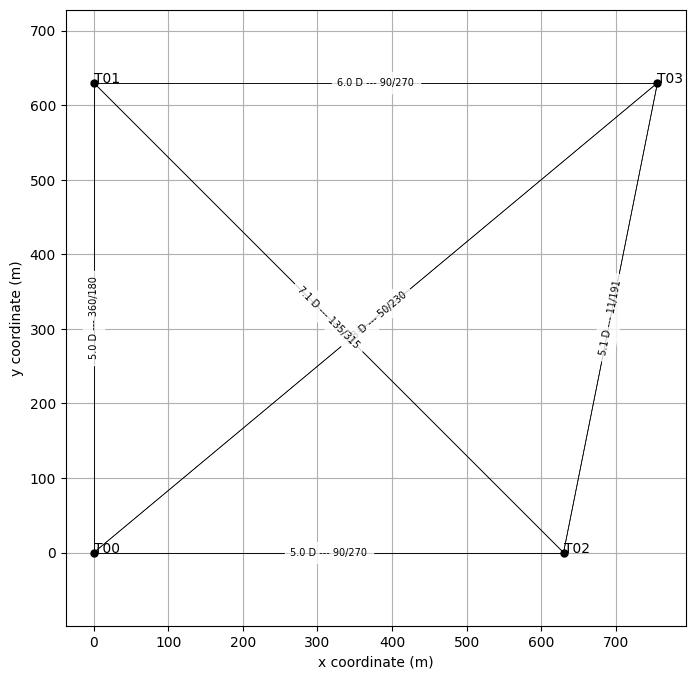

In [2]:
file_path = Path.cwd()
fi_path = file_path / "../floris_input_artificial/gch.yaml"
print(fi_path)
fi = wfct.floris_interface.FlorisInterface(fi_path)
fi.reinitialize(layout_x = [0, 0, 5*126, 6*126], layout_y = [0, 5*126, 0, 5*126])

# # Show the wind farm
plot_layout_with_waking_directions(fi)

Num Points 500


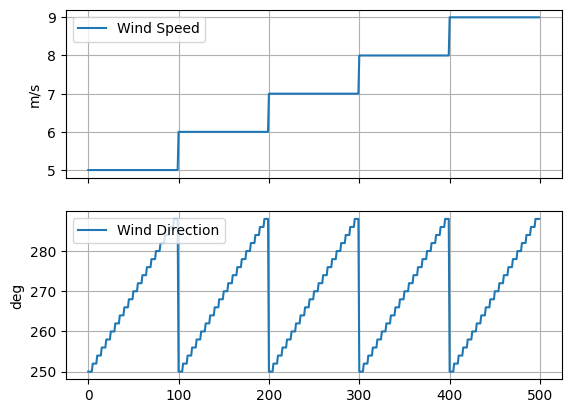

In [3]:
# Create a time history of points where the wind speed and wind direction step different combinations
ws_points = np.arange(5.0,10.0,1.0)
wd_points = np.arange(250.0, 290.0, 2,)
num_points_per_combination = 5 # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
ws_array = []
wd_array = []
for ws in ws_points:
    for wd in wd_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))

print(f'Num Points {len(t)}')

fig, axarr = plt.subplots(2,1,sharex=True)
axarr[0].plot(t, ws_array,label='Wind Speed')
axarr[0].set_ylabel('m/s')
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array,label='Wind Direction')
axarr[1].set_ylabel('deg')
axarr[1].legend()
axarr[1].grid(True)

In [4]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fi.reinitialize(wind_speeds=ws_array, wind_directions=wd_array, time_series=True)
fi.calculate_wake()

# Collect the turbine powers
power_0 = fi.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_1 = fi.get_turbine_powers().squeeze()[:,1].flatten() / 1000.
power_2 = fi.get_turbine_powers().squeeze()[:,2].flatten() / 1000.
power_3 = fi.get_turbine_powers().squeeze()[:,3].flatten() / 1000.

# Assume all turbine measure wind direction with some noise
wd_0 = wd_array + np.random.randn(len(wd_array))*2
wd_1 = wd_array + np.random.randn(len(wd_array))*2
wd_2 = wd_array + np.random.randn(len(wd_array))*2
wd_3 = wd_array + np.random.randn(len(wd_array))*2

# Only collect the wind speeds of the upstream turbines
ws_0 = ws_array + np.random.randn(len(wd_array))*1
ws_1 = ws_array + np.random.randn(len(wd_array))*1

In [5]:
# Now build the dataframe
df = pd.DataFrame({
    'pow_000':power_0,
    'pow_001':power_1,
    'pow_002':power_2,
    'pow_003':power_3,
    'ws_000':ws_0,
    'ws_001':ws_1,
    'wd_000':wd_0,
    'wd_001':wd_1,
    'wd_002':wd_2,
    'wd_003':wd_3,
})

In [6]:
# Build the energy ratio input
er_in = EnergyRatioInput([df], 
                            ['baseline'],
                            num_blocks=10)

array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

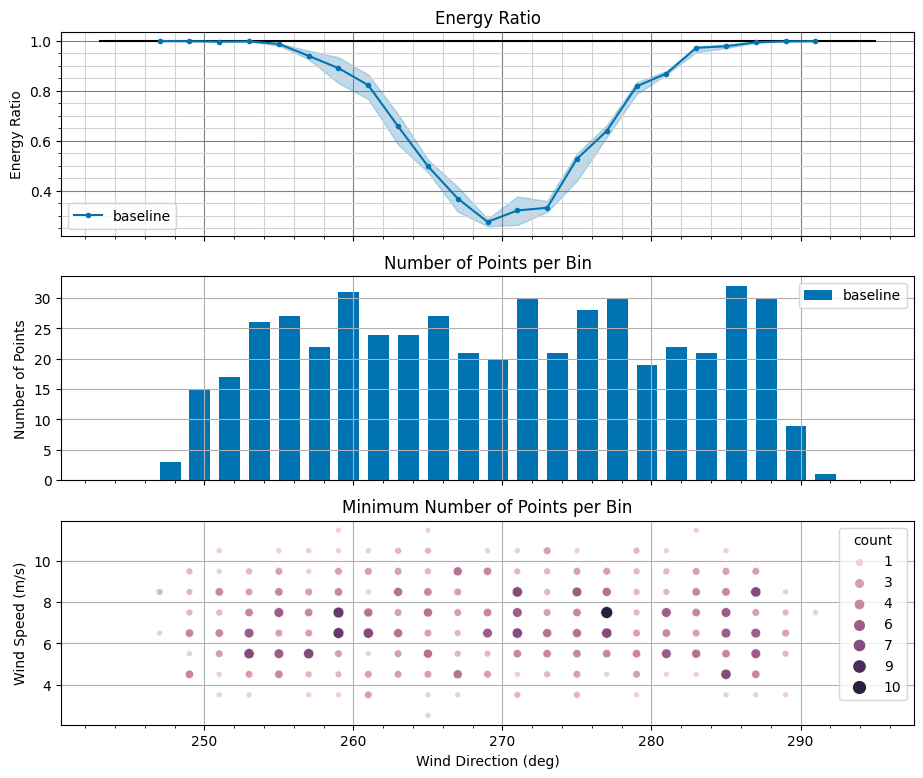

In [7]:
# Calculate and plot the energy ratio of turbine 2 with respect to turbine 0, using turbine 0's measurements of wind speed and wind direction
er_out = erp.compute_energy_ratio(er_in,
                                  test_turbines=[2],
                                    ref_turbines=[0],
                                    ws_turbines=[0],
                                    wd_turbines=[0],
                                    N=50
                                  )
er_out.plot_energy_ratios()

array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

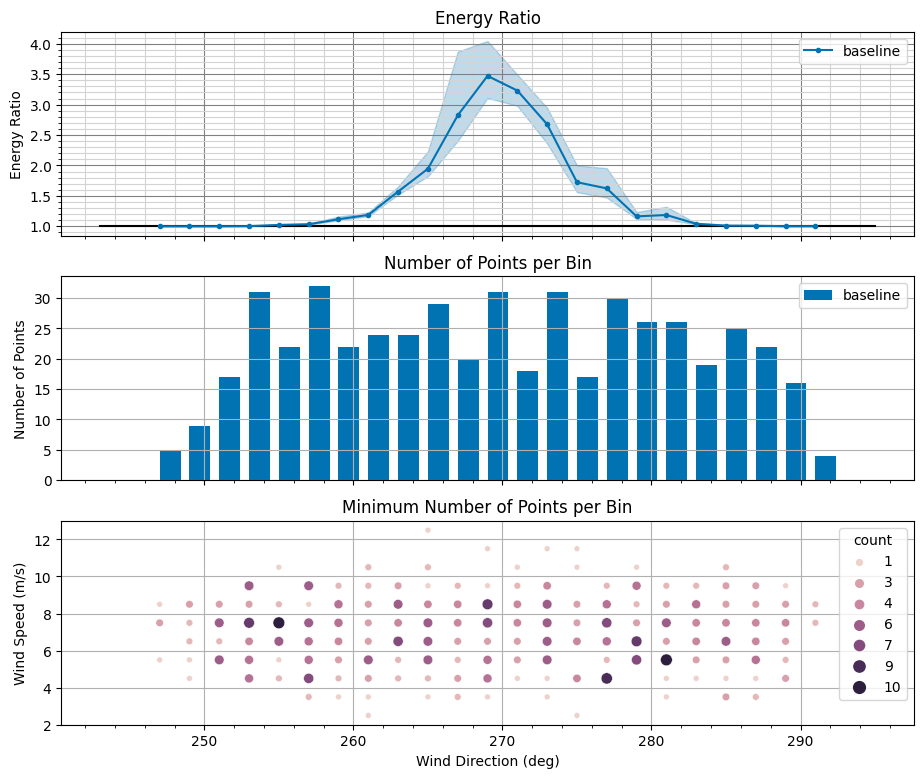

In [8]:
# Reverse the above calculation showing the energy ratio of T0 / T2, letting T1 supply wind speed and direction
er_out = erp.compute_energy_ratio(er_in,
                                  test_turbines=[0],
                                    ref_turbines=[2],
                                    ws_turbines=[1],
                                    wd_turbines=[1],
                                    N=50
                                  )
er_out.plot_energy_ratios()

<Axes: title={'center': 'Energy Ratio'}, xlabel='Wind Direction (deg)', ylabel='Energy Ratio'>

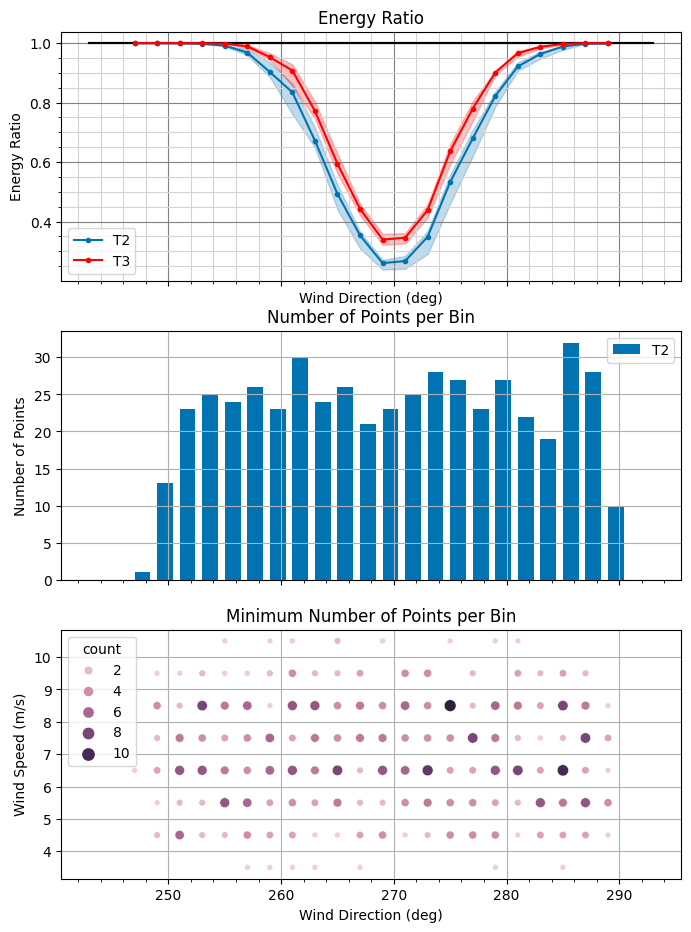

In [9]:
# Overplot the energy ratios of turbine 2 and 3, with respect to the averages of turbines 0 and 1
er_out_2 = erp.compute_energy_ratio(er_in,
                                  test_turbines=[2],
                                    ref_turbines=[0,1],
                                    ws_turbines=[0,1],
                                    wd_turbines=[0,1],
                                    N=50
                                  )

er_out_3 = erp.compute_energy_ratio(er_in,
                                    test_turbines=[3],
                                    ref_turbines=[0,1],
                                    ws_turbines=[0,1],
                                    wd_turbines=[0,1],
                                    N=50
                                  )

fig, axarr = plt.subplots(3,1,sharex=True, figsize=(8,11))

er_out_2.plot_energy_ratios(axarr=axarr,labels='T2')
er_out_3.plot_energy_ratios(axarr=axarr[0],show_wind_direction_distribution=False, show_wind_speed_distribution=False,labels='T3',color_dict={'T3':'r'})



## Illustrating pre-computing reference wind speed, direction and power

In [10]:
# Use the FLASC function for defining wind speed and direction via upstream turbines

df = dfm.set_wd_by_all_turbines(df)
df = dfm.set_ws_by_turbines(df, [0.1])
df = dfm.set_pow_ref_by_turbines(df, [0.1])

df.head()

,pow_000,pow_001,pow_002,pow_003,ws_000,ws_001,wd_000,wd_001,wd_002,wd_003,wd,ws,pow_ref
0,383.695142,383.695142,383.588139,383.687927,4.409294,4.693774,249.993052,252.479891,246.541930,250.178672,249.798579,4.409294,383.695142
1,383.695142,383.695142,383.588139,383.687927,4.591071,5.391175,248.418343,250.215935,253.226271,250.401486,250.565396,4.591071,383.695142
2,383.695142,383.695142,383.588139,383.687927,6.895169,5.658858,251.114722,250.376022,246.939973,246.850226,248.820216,6.895169,383.695142
3,383.695142,383.695142,383.588139,383.687927,5.635877,4.070403,250.866779,252.124793,247.221011,250.753839,250.241866,5.635877,383.695142
4,383.695142,383.695142,383.588139,383.687927,4.108357,4.668947,248.301082,248.092354,252.837257,251.667213,250.224425,4.108357,383.695142


array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

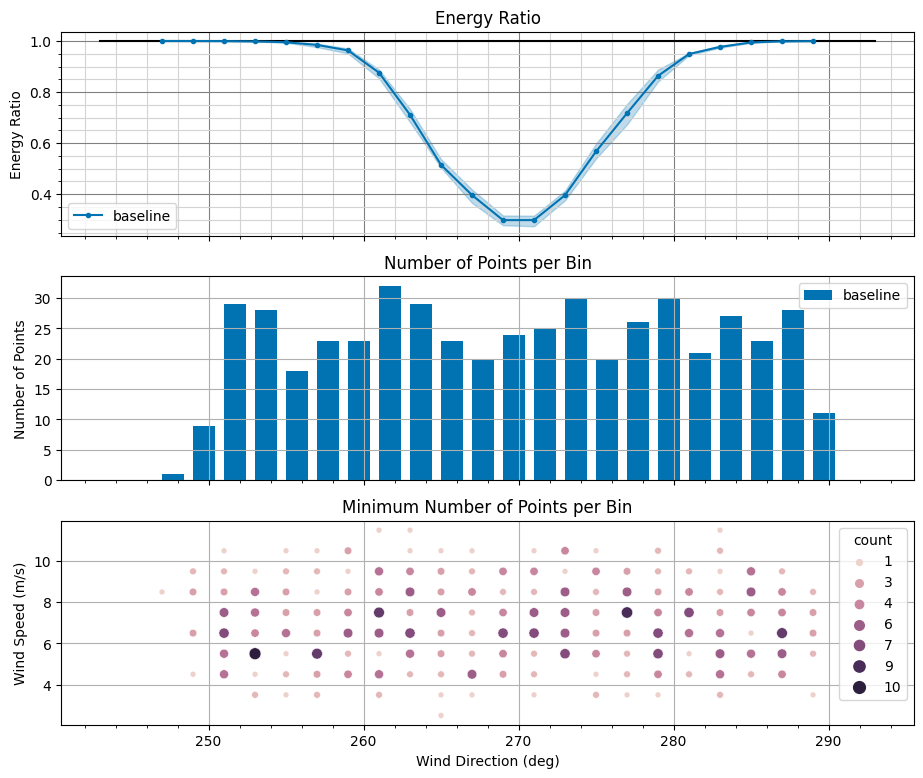

In [11]:
# Now use the predefined values in the calculation of the average of turbines 2 and 3

er_in = EnergyRatioInput([df], 
                            ['baseline'],
                            num_blocks=10)

er_out = erp.compute_energy_ratio(er_in,
                                  test_turbines=[2, 3],
                                  use_predefined_ref = True,
                                  use_predefined_wd = True,
                                  use_predefined_ws = True,
                                  N=50
                                  )
er_out.plot_energy_ratios()